In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy
import os
from sklearn.preprocessing import StandardScaler

In [2]:
#import motion dataframe of only participant 1
motion1 = pd.read_pickle('DFs/Participant_Motion/PID_motion_1.pkl')

Reminder of what each look like

In [3]:
motion1.head(), motion1.shape

(         X         Y         Z  PID
 0  159.596  1845.594  1732.156    1
 1  159.583  1845.451  1732.144    1
 2  159.584  1845.308  1732.126    1
 3  159.587  1845.180  1732.105    1
 4  159.597  1845.072  1732.103    1,
 (36001, 4))

In [4]:
motion1.describe()

,X,Y,Z,PID
count,36001.000000,36001.000000,36001.000000,36001.0
mean,160.456958,1860.184987,1724.088614,1.0
std,4.317600,11.164595,6.404407,0.0
min,144.325000,1829.400000,1715.278000,1.0
25%,158.102000,1852.813000,1718.380000,1.0
50%,161.018000,1859.077000,1721.902000,1.0
75%,163.689000,1866.659000,1732.118000,1.0
max,170.325000,1901.478000,1733.874000,1.0


We need to create a time index to allow for resampling. THis will allow us to reduce our rows and therefore our compute time while also simplifying our sync up to the music data.

In [5]:
#Create datetime index
time = pd.date_range(start='00:00', freq='10L', periods=36001)
time.dtype

dtype('<M8[ns]')

In [6]:
time = time.strftime('%M:%S.%f')
time.dtype

dtype('O')

In [7]:
#set datetime index
motiont = motion1.set_index(time)

In [8]:
motiont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36001 entries, 00:00.000000 to 06:00.000000
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       36001 non-null  float64
 1   Y       36001 non-null  float64
 2   Z       36001 non-null  float64
 3   PID     36001 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 1.4+ MB


In [9]:
motiont.index = pd.to_datetime(motiont.index, format='%M:%S.%f')

In [10]:
motiont.shape

(36001, 4)

In [11]:
motiont

,X,Y,Z,PID
1900-01-01 00:00:00.000,159.596,1845.594,1732.156,1
1900-01-01 00:00:00.010,159.583,1845.451,1732.144,1
1900-01-01 00:00:00.020,159.584,1845.308,1732.126,1
1900-01-01 00:00:00.030,159.587,1845.180,1732.105,1
1900-01-01 00:00:00.040,159.597,1845.072,1732.103,1
...,...,...,...,...
1900-01-01 00:05:59.960,160.090,1837.312,1715.629,1
1900-01-01 00:05:59.970,160.122,1837.488,1715.619,1
1900-01-01 00:05:59.980,160.128,1837.653,1715.597,1
1900-01-01 00:05:59.990,160.147,1837.829,1715.599,1


Now that we have a datetime index, we can resample to 2 tenths of second or 200 milliseconds. We could choose a different value, but this is a good balance between reduce the size of the data for computation reasons as well as keeping enough data to be useful. We will use average values, which will also help with smoothing out some of the noise.

In [12]:
#set the music dataframe index to a time series and upsamplt to match the 100 readings per second from the motion data
motionr = motiont.resample('200L').mean()

In [13]:
def Import_Participant_Motion(par_list):
    #import each participant motion data from the file, add datetime index and resample to 2 tenths of a second
    #output dictionary of dataframes of motion
    output = {}
    time = pd.date_range(start='00:00', freq='10L', periods=35601)
    time = time.strftime('%M:%S.%f')
    for participant in par_list:
        motiont = pd.read_pickle('DFs/Participant_Motion/' + participant)
        motiont = motiont.iloc[:35601].set_index(time)
        motiont.index = pd.to_datetime(motiont.index, format='%M:%S.%f')
        motionr = motiont.resample('200L').mean()
        motionr = motionr.reset_index()
        motionr.rename({'index':'time'}, axis=1)
        output[participant[:-4]] = motionr
    return output

There is some variation for the total length of motion data across the participants. We have limitied the data to the smallest value which cuts off the last 4 seconds of the recordings so as to cause bias by using data at the end of the song that is only from a limited section of participants

In [14]:
par_motion_list = os.listdir('DFs/Participant_Motion')
motion_dict = Import_Participant_Motion(par_motion_list)

In [15]:
motion_dict['PID_motion_41']

,index,X,Y,Z,PID
0,1900-01-01 00:00:00.000,1706.62340,1848.53075,1739.48405,41
1,1900-01-01 00:00:00.200,1706.85740,1848.91400,1739.44225,41
2,1900-01-01 00:00:00.400,1706.15845,1848.61925,1739.42635,41
3,1900-01-01 00:00:00.600,1705.91735,1848.96205,1739.43490,41
4,1900-01-01 00:00:00.800,1706.05450,1849.80710,1739.45795,41
...,...,...,...,...,...
1776,1900-01-01 00:05:55.200,1708.77475,1857.54725,1732.28735,41
1777,1900-01-01 00:05:55.400,1708.91525,1858.51175,1732.28700,41
1778,1900-01-01 00:05:55.600,1709.05760,1858.03235,1732.31015,41
1779,1900-01-01 00:05:55.800,1708.02540,1855.26135,1732.37690,41


We will now add some features that we can use for our model as well as for further EDA. These features use data from the individual participants so it is simpler to create them prior to joining all of the data together.
- disp_start - The distance from the starting location at each point (not a sum)
- scale_mean - The position scaled by the mean causing the mean for all samples to be zero
- disp - absololute value of displacement per step
- total_disp - sum of disp from start 
- target_10 - Target for prediction, 10s ahead
- target_5 - Target for prediction, 5s ahead
- target_20 - Target for prediction, 20s ahead
- *_*s_avg - Average of noted variable for last amount of seconds
- *_*s_min - Min of noted variable for last amount of seconds
- *_*s_max - Max of noted variable for last amount of seconds

In [16]:
#Creating features do be used in the model later. Indivdualized for each PID
for key in motion_dict.keys():
    
    #Displacement from starting position
    motion_dict[key]['X_disp_start'] = motion_dict[key]['X'] - motion_dict[key]['X'][0]
    motion_dict[key]['Y_disp_start'] = motion_dict[key]['Y'] - motion_dict[key]['Y'][0]
    motion_dict[key]['Z_disp_start'] = motion_dict[key]['Z'] - motion_dict[key]['Z'][0]
    
    #Step displacement scaled by centering around mean, mean = 0
    motion_dict[key]['X_scale_mean'] = motion_dict[key]['X'] - motion_dict[key]['X'].mean()
    motion_dict[key]['Y_scale_mean'] = motion_dict[key]['Y'] - motion_dict[key]['Y'].mean()
    motion_dict[key]['Z_scale_mean'] = motion_dict[key]['Z'] - motion_dict[key]['Z'].mean()
    
    #Absolute Value of step displacement
    motion_dict[key]['X_disp'] = abs(motion_dict[key]['X'].diff())
    motion_dict[key]['Y_disp'] = abs(motion_dict[key]['Y'].diff())
    motion_dict[key]['Z_disp'] = abs(motion_dict[key]['Z'].diff())
    
    #Total displacement since start
    motion_dict[key]['X_disp_total'] = motion_dict[key]['X_disp'].cumsum()
    motion_dict[key]['Y_disp_total'] = motion_dict[key]['Y_disp'].cumsum()
    motion_dict[key]['Z_disp_total'] = motion_dict[key]['Z_disp'].cumsum()
    
    #Step Euclidean Distance
    motion_dict[key]['step_eucl'] = np.sqrt(motion_dict[key]['X_disp']**2 + motion_dict[key]['Y_disp']**2 + motion_dict[key]['Z_disp']**2)
    
    #Total Euclidean Distance since start
    motion_dict[key]['total_eucl'] = np.sqrt(motion_dict[key]['X_disp_total']**2 + motion_dict[key]['Y_disp_total']**2 + motion_dict[key]['Z_disp_total']**2)
    
    #Target variables - sum of euclidean distance traveled over 5, 10 and 20 seconds
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=50)
    motion_dict[key]['target_5'] = motion_dict[key]['step_eucl'].rolling(window=indexer).sum()
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=100)
    motion_dict[key]['target_10'] = motion_dict[key]['step_eucl'].rolling(window=indexer).sum()
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=200)
    motion_dict[key]['target_20'] = motion_dict[key]['step_eucl'].rolling(window=indexer).sum()
    
    #Average, Min and Max displacements in X Direction
    motion_dict[key]['X_5s_avg'] = motion_dict[key]['X_disp'].diff().rolling(50).mean()
    motion_dict[key]['X_5s_min'] = motion_dict[key]['X_disp'].diff().rolling(50).min()
    motion_dict[key]['X_5s_max'] = motion_dict[key]['X_disp'].diff().rolling(50).max() 
    motion_dict[key]['X_10s_avg'] = motion_dict[key]['X_disp'].diff().rolling(100).mean()
    motion_dict[key]['X_10s_min'] = motion_dict[key]['X_disp'].diff().rolling(100).min()
    motion_dict[key]['X_10s_max'] = motion_dict[key]['X_disp'].diff().rolling(100).max() 
    motion_dict[key]['X_20s_avg'] = motion_dict[key]['X_disp'].diff().rolling(200).mean()
    motion_dict[key]['X_20s_min'] = motion_dict[key]['X_disp'].diff().rolling(200).min()
    motion_dict[key]['X_20s_max'] = motion_dict[key]['X_disp'].diff().rolling(200).max()     
    
    #Average, Min and Max displacements in Y Direction
    motion_dict[key]['Y_5s_avg'] = motion_dict[key]['Y_disp'].diff().rolling(50).mean()
    motion_dict[key]['Y_5s_min'] = motion_dict[key]['Y_disp'].diff().rolling(50).min()
    motion_dict[key]['Y_5s_max'] = motion_dict[key]['Y_disp'].diff().rolling(50).max()
    motion_dict[key]['Y_10s_avg'] = motion_dict[key]['Y_disp'].diff().rolling(100).mean()
    motion_dict[key]['Y_10s_min'] = motion_dict[key]['Y_disp'].diff().rolling(100).min()
    motion_dict[key]['Y_10s_max'] = motion_dict[key]['Y_disp'].diff().rolling(100).max()
    motion_dict[key]['Y_20s_avg'] = motion_dict[key]['Y_disp'].diff().rolling(200).mean()
    motion_dict[key]['Y_20s_min'] = motion_dict[key]['Y_disp'].diff().rolling(200).min()
    motion_dict[key]['Y_20s_max'] = motion_dict[key]['Y_disp'].diff().rolling(200).max() 
    
    #Average, Min and Max displacements in Z Direction
    motion_dict[key]['Z_5s_avg'] = motion_dict[key]['Z_disp'].diff().rolling(50).mean()
    motion_dict[key]['Z_5s_min'] = motion_dict[key]['Z_disp'].diff().rolling(50).min()
    motion_dict[key]['Z_5s_max'] = motion_dict[key]['Z_disp'].diff().rolling(50).max()
    motion_dict[key]['Z_10s_avg'] = motion_dict[key]['Z_disp'].diff().rolling(100).mean()
    motion_dict[key]['Z_10s_min'] = motion_dict[key]['Z_disp'].diff().rolling(100).min()
    motion_dict[key]['Z_10s_max'] = motion_dict[key]['Z_disp'].diff().rolling(100).max()
    motion_dict[key]['Z_20s_avg'] = motion_dict[key]['Z_disp'].diff().rolling(200).mean()
    motion_dict[key]['Z_20s_min'] = motion_dict[key]['Z_disp'].diff().rolling(200).min()
    motion_dict[key]['Z_20s_max'] = motion_dict[key]['Z_disp'].diff().rolling(200).max() 
    
    #Average, Min and Max displacements in Z Direction
    motion_dict[key]['step_eucl_5s_avg'] = motion_dict[key]['step_eucl'].diff().rolling(50).mean()
    motion_dict[key]['step_eucl_5s_min'] = motion_dict[key]['step_eucl'].diff().rolling(50).min()
    motion_dict[key]['step_eucl_5s_max'] = motion_dict[key]['step_eucl'].diff().rolling(50).max()
    motion_dict[key]['step_eucl_10s_avg'] = motion_dict[key]['step_eucl'].diff().rolling(100).mean()
    motion_dict[key]['step_eucl_10s_min'] = motion_dict[key]['step_eucl'].diff().rolling(100).min()
    motion_dict[key]['step_eucl_10s_max'] = motion_dict[key]['step_eucl'].diff().rolling(100).max()
    motion_dict[key]['step_eucl_20s_avg'] = motion_dict[key]['step_eucl'].diff().rolling(200).mean()
    motion_dict[key]['step_eucl_20s_min'] = motion_dict[key]['step_eucl'].diff().rolling(200).min()
    motion_dict[key]['step_eucl_20s_max'] = motion_dict[key]['step_eucl'].diff().rolling(200).max() 
   

In [17]:
motion_dict['PID_motion_27']

,index,X,Y,Z,PID,X_disp_start,Y_disp_start,Z_disp_start,X_scale_mean,Y_scale_mean,...,Z_20s_max,step_eucl_5s_avg,step_eucl_5s_min,step_eucl_5s_max,step_eucl_10s_avg,step_eucl_10s_min,step_eucl_10s_max,step_eucl_20s_avg,step_eucl_20s_min,step_eucl_20s_max
0,1900-01-01 00:00:00.000,853.88850,200.05315,1575.68605,27,0.00000,0.00000,0.00000,-0.93649,4.857996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-01-01 00:00:00.200,853.03505,201.20170,1575.69445,27,-0.85345,1.14855,0.00840,-1.78994,6.006546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-01-01 00:00:00.400,852.34180,202.59190,1575.70650,27,-1.54670,2.53875,0.02045,-2.48319,7.396746,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-01-01 00:00:00.600,852.38745,203.73950,1575.64450,27,-1.50105,3.68635,-0.04155,-2.43754,8.544346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-01-01 00:00:00.800,852.07915,203.89520,1575.55965,27,-1.80935,3.84205,-0.12640,-2.74584,8.700046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,1900-01-01 00:05:55.200,858.31840,217.06195,1573.06160,27,4.42990,17.00880,-2.62445,3.49341,21.866796,...,0.24175,0.006967,-1.730216,1.400916,-0.005417,-1.730216,1.400916,-0.004955,-2.303691,2.853372
1777,1900-01-01 00:05:55.400,858.01910,215.36410,1573.07865,27,4.13060,15.31095,-2.60740,3.19411,20.168946,...,0.24175,0.012007,-1.730216,1.400916,0.000889,-1.730216,1.400916,0.001047,-2.303691,2.853372
1778,1900-01-01 00:05:55.600,857.58710,213.16935,1573.18885,27,3.69860,13.11620,-2.49720,2.76211,17.974196,...,0.24175,0.017643,-1.730216,1.400916,0.008942,-1.730216,1.400916,0.003363,-2.303691,2.853372
1779,1900-01-01 00:05:55.800,857.96945,211.55325,1573.18025,27,4.08095,11.50010,-2.50580,3.14446,16.358096,...,0.24175,0.016609,-1.730216,1.400916,-0.007295,-1.730216,1.400916,0.006755,-2.303691,2.853372


In [18]:
#create a single dataframe with all motion data that is resampled and includes features
motion_all = pd.concat([motion_dict[key] for key in motion_dict.keys()])
motion_all.sort_values(by=['index', 'PID']).reset_index(drop=True)

,index,X,Y,Z,PID,X_disp_start,Y_disp_start,Z_disp_start,X_scale_mean,Y_scale_mean,...,Z_20s_max,step_eucl_5s_avg,step_eucl_5s_min,step_eucl_5s_max,step_eucl_10s_avg,step_eucl_10s_min,step_eucl_10s_max,step_eucl_20s_avg,step_eucl_20s_min,step_eucl_20s_max
0,1900-01-01 00:00:00,159.69750,1844.71755,1732.09535,1,0.00000,0.00000,0.00000,-0.776898,-15.612761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-01-01 00:00:00,927.24265,1928.86990,1696.30070,2,0.00000,0.00000,0.00000,0.365386,-53.140986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-01-01 00:00:00,1737.95595,1892.14615,1640.89155,3,0.00000,0.00000,0.00000,2.215488,-17.477088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-01-01 00:00:00,2546.73955,1799.38010,1745.78055,4,0.00000,0.00000,0.00000,-9.634258,-24.123728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-01-01 00:00:00,159.32390,244.40325,1644.58385,5,0.00000,0.00000,0.00000,-5.153143,3.625311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130008,1900-01-01 00:05:56,1718.48000,1076.27400,1860.49700,70,-0.73570,-33.30925,2.78615,-1.764973,-28.128859,...,0.09175,0.005851,-1.381444,1.501721,0.002587,-1.381444,1.501721,0.002968,-1.381444,1.501721
130009,1900-01-01 00:05:56,2517.84100,1076.63400,1724.79500,71,7.92765,-47.74315,16.15045,7.502857,-4.285337,...,0.76625,-0.018823,-2.142948,1.913807,-0.006733,-2.142948,2.016891,-0.001121,-2.142948,2.206250
130010,1900-01-01 00:05:56,21.73200,292.99900,1696.31100,72,-12.09025,98.34305,-20.17745,-4.318562,42.458974,...,0.37990,0.013442,-1.570258,2.340385,-0.006342,-2.629934,2.340385,0.002754,-2.629934,2.573455
130011,1900-01-01 00:05:56,870.40200,162.06400,1727.47800,73,9.71625,21.97030,-0.72000,-2.410830,13.610233,...,0.18605,-0.007016,-1.195001,1.425335,-0.000172,-1.195001,1.425335,0.000257,-1.446597,1.451049


In [19]:
#Add a millisecond column that counts milliseconds from start. An 'int' as opposed to datetime
motion_all['millisecond'] = (motion_all['index'].dt.microsecond + motion_all['index'].dt.second*1000000 + motion_all['index'].dt.minute*60*1000000)/1000
motion_all

,index,X,Y,Z,PID,X_disp_start,Y_disp_start,Z_disp_start,X_scale_mean,Y_scale_mean,...,step_eucl_5s_avg,step_eucl_5s_min,step_eucl_5s_max,step_eucl_10s_avg,step_eucl_10s_min,step_eucl_10s_max,step_eucl_20s_avg,step_eucl_20s_min,step_eucl_20s_max,millisecond
0,1900-01-01 00:00:00.000,159.69750,1844.71755,1732.09535,1,0.00000,0.00000,0.00000,-0.776898,-15.612761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1900-01-01 00:00:00.200,160.21170,1844.63625,1732.06770,1,0.51420,-0.08130,-0.02765,-0.262698,-15.694061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0
2,1900-01-01 00:00:00.400,160.53550,1846.72830,1732.12305,1,0.83800,2.01075,0.02770,0.061102,-13.602011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0
3,1900-01-01 00:00:00.600,160.62530,1849.30315,1732.22560,1,0.92780,4.58560,0.13025,0.150902,-11.027161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.0
4,1900-01-01 00:00:00.800,160.51940,1850.78495,1732.32555,1,0.82190,6.06740,0.23020,0.045002,-9.545361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,1900-01-01 00:05:55.200,102.32110,1994.32300,1804.84125,9,-22.22595,32.45885,-5.16410,-9.970365,10.892154,...,0.007176,-1.572734,2.138834,0.008424,-2.197822,2.138834,0.001199,-2.793844,2.138834,355200.0
1777,1900-01-01 00:05:55.400,102.42525,1995.53835,1804.84630,9,-22.12180,33.67420,-5.15905,-9.866215,12.107504,...,-0.009806,-1.572734,2.138834,0.006594,-2.197822,2.138834,-0.000423,-2.793844,2.138834,355400.0
1778,1900-01-01 00:05:55.600,102.54620,1996.00075,1804.89800,9,-22.00085,34.13660,-5.10735,-9.745265,12.569904,...,-0.032304,-1.572734,2.138834,-0.004084,-2.197822,2.138834,-0.001749,-2.793844,2.138834,355600.0
1779,1900-01-01 00:05:55.800,102.80250,1995.31755,1804.95805,9,-21.74455,33.45340,-5.04730,-9.488965,11.886704,...,0.004179,-1.417568,2.138834,-0.005251,-2.197822,2.138834,-0.001009,-2.793844,2.138834,355800.0


In [20]:
def add_segment(df, col='millisecond'):
    #adds segment of music label to dataset based on millisecond column being present
    df['segment'] = 'silence'
    df.loc[motion_all[col].between(180000, 200000), 'segment'] = 'class1'
    df.loc[motion_all[col].between(200000, 215000), 'segment'] = 'class2'
    df.loc[motion_all[col].between(215000, 255000), 'segment'] = 'class3'
    df.loc[motion_all[col].between(255000, 275000), 'segment'] = 'class4'
    df.loc[motion_all[col].between(275000, 310000), 'segment'] = 'hiphop'
    df.loc[motion_all[col].between(310000, 330000), 'segment'] = 'salsa'
    df.loc[motion_all[col].between(330000, 356000), 'segment'] = 'edm'

Now that we have a single set to work with lets take a look at some of the average movements compared to the music

In [21]:
add_segment(motion_all)
motion_all

,index,X,Y,Z,PID,X_disp_start,Y_disp_start,Z_disp_start,X_scale_mean,Y_scale_mean,...,step_eucl_5s_min,step_eucl_5s_max,step_eucl_10s_avg,step_eucl_10s_min,step_eucl_10s_max,step_eucl_20s_avg,step_eucl_20s_min,step_eucl_20s_max,millisecond,segment
0,1900-01-01 00:00:00.000,159.69750,1844.71755,1732.09535,1,0.00000,0.00000,0.00000,-0.776898,-15.612761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,silence
1,1900-01-01 00:00:00.200,160.21170,1844.63625,1732.06770,1,0.51420,-0.08130,-0.02765,-0.262698,-15.694061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,silence
2,1900-01-01 00:00:00.400,160.53550,1846.72830,1732.12305,1,0.83800,2.01075,0.02770,0.061102,-13.602011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,silence
3,1900-01-01 00:00:00.600,160.62530,1849.30315,1732.22560,1,0.92780,4.58560,0.13025,0.150902,-11.027161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.0,silence
4,1900-01-01 00:00:00.800,160.51940,1850.78495,1732.32555,1,0.82190,6.06740,0.23020,0.045002,-9.545361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800.0,silence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,1900-01-01 00:05:55.200,102.32110,1994.32300,1804.84125,9,-22.22595,32.45885,-5.16410,-9.970365,10.892154,...,-1.572734,2.138834,0.008424,-2.197822,2.138834,0.001199,-2.793844,2.138834,355200.0,edm
1777,1900-01-01 00:05:55.400,102.42525,1995.53835,1804.84630,9,-22.12180,33.67420,-5.15905,-9.866215,12.107504,...,-1.572734,2.138834,0.006594,-2.197822,2.138834,-0.000423,-2.793844,2.138834,355400.0,edm
1778,1900-01-01 00:05:55.600,102.54620,1996.00075,1804.89800,9,-22.00085,34.13660,-5.10735,-9.745265,12.569904,...,-1.572734,2.138834,-0.004084,-2.197822,2.138834,-0.001749,-2.793844,2.138834,355600.0,edm
1779,1900-01-01 00:05:55.800,102.80250,1995.31755,1804.95805,9,-21.74455,33.45340,-5.04730,-9.488965,11.886704,...,-1.417568,2.138834,-0.005251,-2.197822,2.138834,-0.001009,-2.793844,2.138834,355800.0,edm


Let's take a quick look at the average movement of the partiicpants over time

In [22]:
mean_motion = motion_all.groupby('index').mean()

In [23]:
mean_motion.drop(columns='PID', inplace=True)

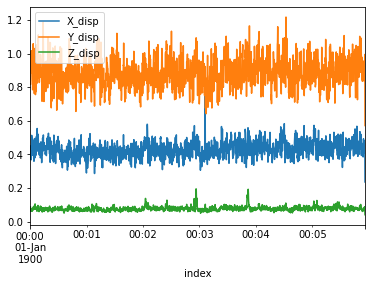

In [24]:
mean_motion[['X_disp', 'Y_disp', 'Z_disp']].plot()
plt.show()

It appears that thre is gerenally more motion in the Y direction then any others. Next comes X and Z follows. I believe that the Y dimension represents forward/backward while the X represents side to side.

Let's confirm that the target variables are calulated as we expect. They should be equal to the a rolling sum shift back either 5, 10 or 20 seconds

<AxesSubplot:>

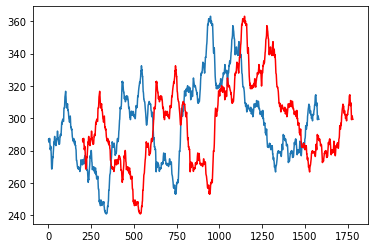

In [25]:
PID_1 = motion_all[motion_all['PID']==1]
PID_1['target_20'].plot()
PID_1['step_eucl'].rolling(200).sum().plot(color='red')

<AxesSubplot:>

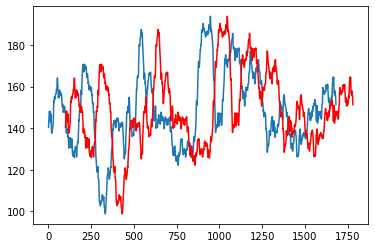

In [26]:
PID_1 = motion_all[motion_all['PID']==1]
PID_1['target_10'].plot()
PID_1['step_eucl'].rolling(100).sum().plot(color='red')

<AxesSubplot:>

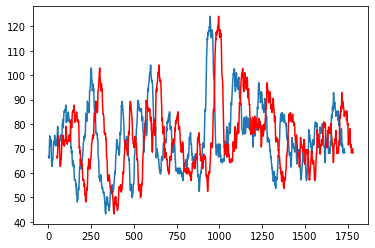

In [27]:
PID_1 = motion_all[motion_all['PID']==1]
PID_1['target_5'].plot()
PID_1['step_eucl'].rolling(50).sum().plot(color='red')

Looking at the above grpahs we can confirm that the target variables are calulated as expected.

In [28]:
motion_all.to_pickle('DFs/motion_all.pkl')